In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [16]:
script_content = """
import os
import hashlib
from PIL import Image
import numpy as np
import shutil

# Folder paths
RAW_DATA_DIR = r'PCOS'
CLEANED_DATA_DIR = 'cleaned_PCOS'  # Output folder for cleaned dataset
IMAGE_SIZE = (240, 240)  # Resize target size

def remove_duplicates_and_resize():
    seen_hashes = set()

    for label in ['infected', 'noninfected']:
        source_dir = os.path.join(RAW_DATA_DIR, label)
        target_dir = os.path.join(CLEANED_DATA_DIR, label)
        os.makedirs(target_dir, exist_ok=True)

        for filename in os.listdir(source_dir):
            file_path = os.path.join(source_dir, filename)

            # Read and hash image
            with open(file_path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            if file_hash in seen_hashes:
                print(f"Duplicate removed: {filename}")
                continue  # Skip duplicate
            seen_hashes.add(file_hash)

            # Load image, resize, and save to cleaned dataset
            try:
                with Image.open(file_path) as img:
                    img = img.convert('L')  # Convert to grayscale
                    img_resized = img.resize(IMAGE_SIZE)
                    cleaned_filename = f"{file_hash}.jpg"
                    cleaned_path = os.path.join(target_dir, cleaned_filename)
                    img_resized.save(cleaned_path, 'JPEG')
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

    print("Cleaning & preprocessing complete.")

def main():
    # Remove old cleaned folder if exists
    if os.path.exists(CLEANED_DATA_DIR):
        shutil.rmtree(CLEANED_DATA_DIR)

    remove_duplicates_and_resize()

if __name__ == '__main__':
    main()
"""

with open("data_cleaning_preprocessing.py", "w") as f:
    f.write(script_content)

print("Script created successfully!")


Script created successfully!


In [17]:
!python data_cleaning_preprocessing.py

Duplicate removed: image10940.jpg
Duplicate removed: image10941.jpg
Duplicate removed: image10942.jpg
Duplicate removed: image10943.jpg
Duplicate removed: image10944.jpg
Duplicate removed: image10945.jpg
Duplicate removed: image10946.jpg
Duplicate removed: image10947.jpg
Duplicate removed: image10948.jpg
Duplicate removed: image10949.jpg
Duplicate removed: image10950.jpg
Duplicate removed: image10951.jpg
Duplicate removed: image10952.jpg
Duplicate removed: image10953.jpg
Duplicate removed: image10954.jpg
Duplicate removed: image10955.jpg
Duplicate removed: image10956.jpg
Duplicate removed: image10957.jpg
Duplicate removed: image10958.jpg
Duplicate removed: image10959.jpg
Duplicate removed: image10960.jpg
Duplicate removed: image10961.jpg
Duplicate removed: image10962.jpg
Duplicate removed: image10963.jpg
Duplicate removed: image10964.jpg
Duplicate removed: image10965.jpg
Duplicate removed: image10966.jpg
Duplicate removed: image10967.jpg
Duplicate removed: image10968.jpg
Duplicate remo

In [2]:
# Import dataset
import os

# infected_path = r"cleaned_PCOS\infected"
# noninfected_path = r"cleaned_PCOS\noninfected"
infected_path = r"PCOS\infected"
noninfected_path = r"PCOS\noninfected"
                
infected = []
noninfected = []

for file in os.listdir(infected_path):
    path = os.path.join(infected_path, file)
    image = load_img(path, target_size=(240, 240))
    image = img_to_array(image)
    image = preprocess_input(image)
    infected.append(image)

for file in os.listdir(noninfected_path):
    path = os.path.join(noninfected_path, file)
    image = load_img(path, target_size=(240, 240))
    image = img_to_array(image)
    image = preprocess_input(image)
    noninfected.append(image)

infected = np.array(infected)
noninfected = np.array(noninfected)

In [3]:
from sklearn.model_selection import train_test_split

x = np.concatenate((infected, noninfected), axis=0)

# infected=1, noninfected=0
y = np.concatenate((
    np.ones(len(infected)), 
    np.zeros(len(noninfected))
), axis=0)

# Splitting train(75%)/test(25%)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42, stratify=y
)

In [4]:
model = VGG16(include_top=False, input_shape=(240, 240, 3))

In [22]:
x_train_FE = model.predict(x_train)
x_test_FE = model.predict(x_test)

277/277 ━━━━━━━━━━━━━━━━━━━━ 1928s 7s/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 624s 7s/step


In [23]:
x_raw_train = x_train_FE.flatten().reshape([x_train_FE.shape[0], -1])
x_raw_test = x_test_FE.flatten().reshape([x_test_FE.shape[0], -1])


In [24]:
import sklearn
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(x_raw_train, y_train)
prediction = clf.predict(x_raw_test)

print("Test accuracy:")
clf.score(x_raw_test, y_test)

Test accuracy:


0.9989816700610998

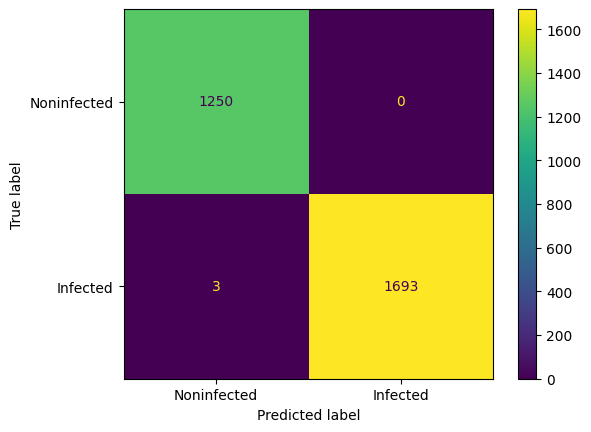

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, prediction)

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, prediction, display_labels=['Noninfected', 'Infected'])
plt.show()